In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import xarray as xr
import subprocess

In [2]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")




https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [3]:
cmap

<xarray.Dataset> Size: 2MB
Dimensions:   (Y: 26, X: 29, T: 559)
Coordinates:
  * Y         (Y) float32 104B 12.0 13.0 14.0 15.0 16.0 ... 34.0 35.0 36.0 37.0
  * X         (X) float32 116B 32.0 33.0 34.0 35.0 36.0 ... 57.0 58.0 59.0 60.0
  * T         (T) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-07-01
Data variables:
    prcp_est  (T, Y, X) float32 2MB ...

In [4]:
#create variable that is the rolling sum of the next 3 months
cmap['rolling_sum'] = cmap['prcp_est'] + cmap['prcp_est'].shift(T=1) + cmap['prcp_est'].shift(T=2)
cmap = cmap.dropna(dim='T')


In [5]:
#count the number of negative values
print('Number of negative values:', cmap['rolling_sum'].where(cmap['rolling_sum'] < 0).count().values)

Number of negative values: 0


In [17]:
x_range = cmap['rolling_sum'].X.values
y_range = cmap['rolling_sum'].Y.values
spi_list = []

for month in range(1, 13): 
    print(f"Processing month: {month}")
    #3month window modulo 12
    # months = [(month - i) % 12 if (month - i) % 12 != 0 else 12 for i in range(3)]
    data_month = cmap['rolling_sum'].sel(T=cmap['T.month']==month)
    
    T_size = len(data_month['T'])
    spi_storage = np.full((T_size, len(y_range), len(x_range)), np.nan)  # Pre-fill with NaNs

    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            data_grid = data_month.sel(X=x, Y=y)
            # Check if the entire grid is NaN
            if np.isnan(data_grid.values).all():
                # All values remain NaN in spi_storage
                continue

            data_grid_climo = data_grid.sel(T=slice('1991-01-01', '2020-12-01'))

            #check if 10% of the values are < 1
            if ((data_grid_climo.values < 1/30).sum() / data_grid_climo.size) > 0.1:
                continue
            else:
                # Fit pearson type III distribution to the data
                #try:
                a, loc, scale = sp.stats.pearson3.fit(data_grid.values)
                    # Calculate the CDF of the Pearson Type III distribution
                cdf_values = sp.stats.pearson3.cdf(data_grid.values, skew=a, loc=loc, scale=scale)
                q = ((np.sum(data_grid.values == 0)) / len(data_grid.values))
                cdf_values = (cdf_values*(1-q)) + q
                    #replace 0 with 1e-6
                cdf_values = np.where(cdf_values < 0.0001, 0.0001, cdf_values)
                    #replace 1 with 1-1e-6
                cdf_values = np.where(cdf_values > 0.9999, 0.9999, cdf_values)
            
                    # Convert CDF to SPI using the inverse normal distribution (PPF)
                spi_storage[:, i, j] = sp.stats.norm.ppf(cdf_values)
                #except (ValueError, RuntimeError) as e:
                    # If fitting fails, leave Nans in the SPI values
                 #   continue
    # Convert the stored SPI values into an xarray DataArray
    spi_month = xr.DataArray(spi_storage, dims=['T', 'Y', 'X'],
                    coords={'T': data_month['T'], 'Y': y_range, 'X': x_range})
    spi_list.append(spi_month)

spi = xr.concat(spi_list, dim='T')

Processing month: 1
Processing month: 2
Processing month: 3
Processing month: 4
Processing month: 5
Processing month: 6
Processing month: 7
Processing month: 8
Processing month: 9
Processing month: 10
Processing month: 11
Processing month: 12


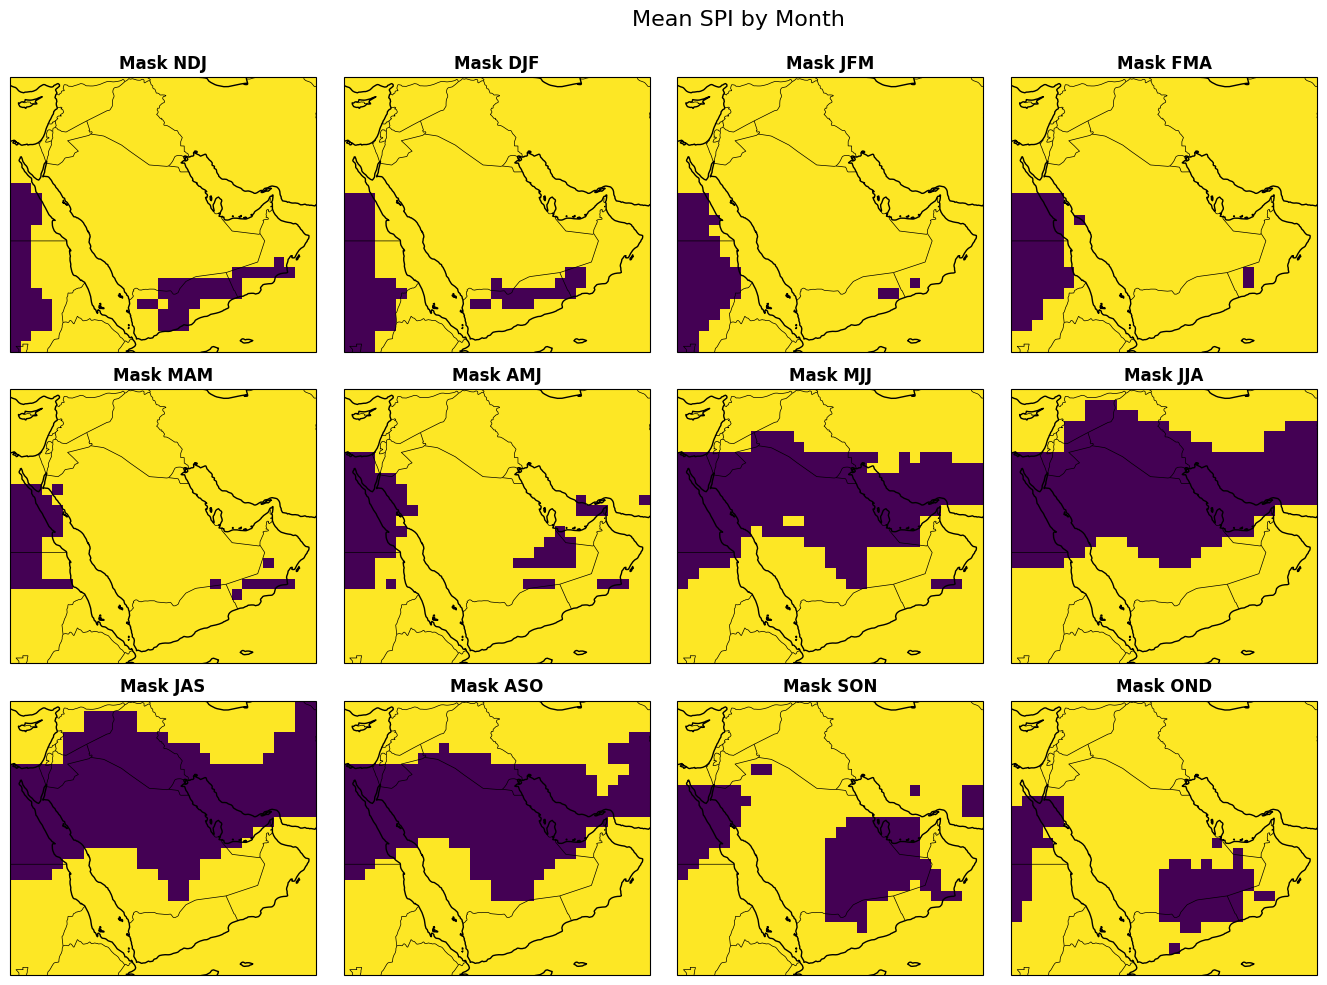

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Calculate monthly mean SPI
spi_monthly_means = spi.groupby('T.month').mean(dim='T')
#turn into boolean 1 if not nan, 0 if nan
spi_monthly_means = spi_monthly_means.notnull().astype(int)

# Create a faceted plot with Cartopy projection
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    3, 4,  # 3 rows, 4 columns for the 12 months
    subplot_kw={'projection': proj},
    figsize=(15, 10)
)
axes = axes.flatten()

# Loop through months and axes
for i, (month, ax) in enumerate(zip(spi_monthly_means.month.values, axes)):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3)

    # Plot mean SPI for the current month
    spi_monthly_means.sel(month=month).plot(
        ax=ax,
        transform=proj,
        #levels = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2],
        #cmap='BrBG',
        add_colorbar=False,  # Disable individual colorbars
    )
    month_strings = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    ax.set_title(f'Mask {month_strings[i]}', fontsize=12, fontweight='bold')

# # Add a shared colorbar
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# plt.colorbar(
#     axes[0].collections[0],  # Use the first plot's QuadMesh for the colorbar
#     cax=cbar_ax,
#     label='SPI'
# )

# Adjust layout and add a title
fig.tight_layout(rect=[0, 0, 0.9, 0.95])  # Make room for the shared colorbar
plt.suptitle('Mean SPI by Month', fontsize=16)

# Show the plot
plt.show()

In [19]:
save = True
if save:
    spi.to_netcdf('data/spi3_cmap_1x1.nc')

# No Dry Mask

In [6]:
x_range = cmap['rolling_sum'].X.values
y_range = cmap['rolling_sum'].Y.values
spi_list = []

for month in range(1, 13): 
    print(f"Processing month: {month}")
    #3month window modulo 12
    # months = [(month - i) % 12 if (month - i) % 12 != 0 else 12 for i in range(3)]
    data_month = cmap['rolling_sum'].sel(T=cmap['T.month']==month)
    
    T_size = len(data_month['T'])
    spi_storage = np.full((T_size, len(y_range), len(x_range)), np.nan)  # Pre-fill with NaNs

    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            data_grid = data_month.sel(X=x, Y=y)
            # Check if the entire grid is NaN
            if np.isnan(data_grid.values).all():
                # All values remain NaN in spi_storage
                continue

            data_grid_climo = data_grid.sel(T=slice('1991-01-01', '2020-12-01'))


            # Fit pearson type III distribution to the data
            #try:
            a, loc, scale = sp.stats.pearson3.fit(data_grid.values)
                # Calculate the CDF of the Pearson Type III distribution
            cdf_values = sp.stats.pearson3.cdf(data_grid.values, skew=a, loc=loc, scale=scale)
            q = ((np.sum(data_grid.values == 0)) / len(data_grid.values))
            cdf_values = (cdf_values*(1-q)) + q
                #replace 0 with 1e-6
            cdf_values = np.where(cdf_values < 0.0001, 0.0001, cdf_values)
                #replace 1 with 1-1e-6
            cdf_values = np.where(cdf_values > 0.9999, 0.9999, cdf_values)
        
                # Convert CDF to SPI using the inverse normal distribution (PPF)
            spi_storage[:, i, j] = sp.stats.norm.ppf(cdf_values)

    # Convert the stored SPI values into an xarray DataArray
    spi_month = xr.DataArray(spi_storage, dims=['T', 'Y', 'X'],
                    coords={'T': data_month['T'], 'Y': y_range, 'X': x_range})
    spi_list.append(spi_month)

spi = xr.concat(spi_list, dim='T')

Processing month: 1
Processing month: 2
Processing month: 3
Processing month: 4
Processing month: 5
Processing month: 6
Processing month: 7
Processing month: 8
Processing month: 9
Processing month: 10
Processing month: 11
Processing month: 12


In [7]:
save = True
if save:
    spi.to_netcdf('data/spi3_cmap_1x1_NOMASK.nc')

In [ ]:
# Simulate from the fitted gamma distribution
a, loc, scale = sp.stats.gamma.fit(point.values)
gamma_values = sp.stats.gamma.rvs(a=a, loc=loc, scale=scale, size=100)

# Calculate the CDF and SPI for gamma distribution
cdf_values = sp.stats.gamma.cdf(point.values, a=a, loc=loc, scale=scale)
q = np.sum(point.values == 0) / len(point.values)
cdf_values = (cdf_values * (1 - q)) + q
cdf_values = np.clip(cdf_values, 0.0001, 0.9999)
spi_values_gamma = sp.stats.norm.ppf(cdf_values)

# Simulate from the fitted Pearson3 distribution
a, loc, scale = sp.stats.pearson3.fit(point.values)
pearson3_values = sp.stats.pearson3.rvs(skew=a, loc=loc, scale=scale, size=100)

q = np.sum(point.values == 0) / len(point.values)
# Calculate the CDF and SPI for Pearson3 distribution
cdf_values = sp.stats.pearson3.cdf(point.values, skew=a, loc=loc, scale=scale)
cdf_values = (cdf_values * (1 - q)) + q
cdf_values = np.clip(cdf_values, 0.0001, 0.9999)
spi_values_pearson3 = sp.stats.norm.ppf(cdf_values)

# Plot histograms of gamma and Pearson3 distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#Plot for gamma distribution
ax[0].hist(gamma_values, bins=10, density=True, alpha=0.5, label="Gamma Simulated")
ax[0].hist(point.values, bins=10, density=True, alpha=0.5, label="Original Data")
ax[0].set_title("Gamma Distribution")
ax[0].legend()

# Plot for Pearson3 distribution
ax[1].hist(pearson3_values, bins=10, density=True, alpha=0.5, label="Pearson3 Simulated")
ax[1].hist(point.values, bins=10, density=True, alpha=0.5, label="Original Data")
ax[1].set_title("Pearson3 Distribution")
ax[1].legend()

plt.show()


In [ ]:
plt.scatter(spi_values_pearson3,cdf_values, label='Pearson3')
plt.scatter(spi_values_gamma,cdf_values, label='Gamma')
plt.legend()

In [ ]:
plt.plot(spi_values_pearson3, label='Pearson3')
plt.plot(spi_values_gamma, label='Gamma')
plt.legend()


# add anomaly and compute correlation